In [62]:
#library used
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml.classification import LogisticRegression
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml import Pipeline
import pandas as pd
import numpy as np
import sklearn
import pandas as pd
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import translate
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import rand,when
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator    
import pyspark.sql.functions as func
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import DecisionTreeClassifier
import pyspark.ml.evaluation as ev

    

In [4]:
Pepe('T4smallsubset.csv')

DataFrame[_c0: string, _c1: bigint, _c2: double, _c3: double, _c4: int, _c5: int, _c6: int, _c7: int, _c8: int, _c9: int, _c10: int, _c11: int, _c12: int, _c13: int, _c14: int, _c15: int, _c16: int, _c17: int, _c18: int, _c19: int, _c20: int, _c21: int, _c22: int, _c23: int, _c24: int, _c25: string, rand: string, _c25_index: double, _c25_encoded: vector, vectorized_features: vector, label: double, features: vector]

In [3]:
#functions to build pipeline
def Pepe(D):

    #reading in data
    spark = SparkSession.builder.master('local[2]').config("spark.executor.memory", "1g").config("spark.driver.memory", "1g").appName('spark_sh_data').getOrCreate()
    df = spark.read.options(header=None, nullValue='NULL', inferSchema=True).option('nullValue','null').csv(D)
    #dealing with null values
    newDf = df.withColumn('_c4', translate('_c4', 'NULL', '')).withColumn('_c5', translate('_c5', 'NULL', '')).withColumn('_c6', translate('_c6', 'NULL', '')).withColumn('_c7', translate('_c7', 'NULL', ''))\
        .withColumn('_c8', translate('_c8', 'NULL', ''))
    newDf1 = newDf.withColumn('_c4', newDf["_c4"].cast(IntegerType())).withColumn('_c5', newDf["_c5"].cast(IntegerType())).withColumn('_c6', newDf["_c6"].cast(IntegerType())).withColumn('_c7', newDf["_c7"].cast(IntegerType()))\
        .withColumn('_c8', newDf["_c8"].cast(IntegerType()))
    
    
    data= newDf1.withColumn('rand', when(rand() > 0.5, 'yes').otherwise('no'))
    
    #string indexer
    stringIndexer = StringIndexer().setInputCol("_c25").setOutputCol("_c25_index").setHandleInvalid("skip")
    _c25_index_model=stringIndexer.fit(data)
    _c25_index_df=_c25_index_model.transform(data)
    
    #encoder
    encoder = OneHotEncoder().setInputCols(["_c25_index"]).setOutputCols(["_c25_encoded"])
    encoder_model=encoder.fit(_c25_index_df)
    encoder_df=encoder_model.transform(_c25_index_df)

    #assembler
    assembler = VectorAssembler().setInputCols(['_c4','_c5','_c6','_c7','_c8','_c9','_c10','_c11','_c12','_c13','_c14','_c15','_c16','_c17','_c18','_c19','_c20','_c21','_c22','_c23','_c24'])\
                        .setOutputCol("vectorized_features")\
                            .setHandleInvalid("skip")
    assembler_df = assembler.transform(encoder_df)
    
    #label indexer
    label_indexer = StringIndexer().setInputCol("rand").setOutputCol("label")
    label_indexer_model=label_indexer.fit(assembler_df)
    label_indexer_df = label_indexer_model.transform(assembler_df)
    
    scaler = StandardScaler().setInputCol("vectorized_features").setOutputCol("features")
    scaler_model=scaler.fit(label_indexer_df)
    scaler_df = scaler_model.transform(label_indexer_df)
    
    #pipeline
    pipeline_stages=Pipeline().setStages([stringIndexer,encoder,assembler,label_indexer,scaler])
    pipeline_model=pipeline_stages.fit(data)
    pipeline_df=pipeline_model.transform(data)
    
    return pipeline_df
    

In [72]:
#log regression
def SherLog(PepePipe):
    #training 80/20
    train, test = PepePipe.randomSplit([0.8,0.2], seed=56)
    from pyspark.ml.classification import DecisionTreeClassifier
    
    evaluator = ev.BinaryClassificationEvaluator(rawPredictionCol='probability', labelCol='label')
    
    #fitting and transform
    lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=5)
    lrModel = lr.fit(train)
    predictions = lrModel.transform(test)
    
    print(evaluator.evaluate(predictions, {evaluator.metricName: 'areaUnderROC'}))
    #print(evaluator.evaluate(dt_pred, {evaluator.metricName: 'areaUnderPR'}))
    
    
    #coefficient model
    beta = np.sort(lrModel.coefficients)
    plt.plot(beta)
    plt.ylabel('Beta Coefficients')
    plt.show()

    #roc curve
    trainingSummary = lrModel.summary
    roc = trainingSummary.roc.toPandas()
    plt.plot(roc['FPR'],roc['TPR'])
    plt.ylabel('False Positive Rate')
    plt.xlabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()
    print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))
    
    #precision 
    pr = trainingSummary.pr.toPandas()
    plt.plot(pr['recall'],pr['precision'])
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.show()
    
    
    
    
    return predictions





0.48412561221549955


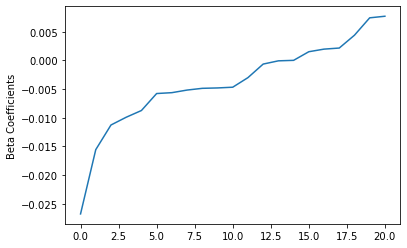

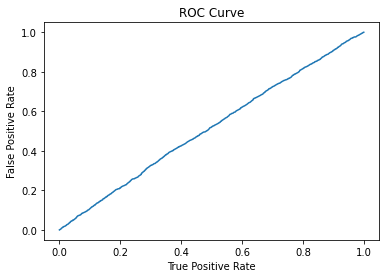

Training set areaUnderROC: 0.5157663139698456


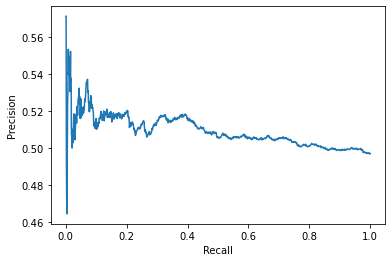

DataFrame[_c0: string, _c1: bigint, _c2: double, _c3: double, _c4: int, _c5: int, _c6: int, _c7: int, _c8: int, _c9: int, _c10: int, _c11: int, _c12: int, _c13: int, _c14: int, _c15: int, _c16: int, _c17: int, _c18: int, _c19: int, _c20: int, _c21: int, _c22: int, _c23: int, _c24: int, _c25: string, rand: string, _c25_index: double, _c25_encoded: vector, vectorized_features: vector, label: double, features: vector, rawPrediction: vector, probability: vector, prediction: double]

In [73]:
SherLog(Pepe('T4smallsubset.csv'))

In [102]:
#Gradient Booster tree 
def MoriarTree(PepePipe):
    #training 80/20
    train, test = PepePipe.randomSplit([0.8, 0.2], seed=56)
    evaluator = ev.BinaryClassificationEvaluator(rawPredictionCol='probability', labelCol='label')
    #fitting and transform
    gbt = GBTClassifier(maxIter=10)
    gbtModel = gbt.fit(train)
    gbt_pred = gbtModel.transform(test)

    print(evaluator.evaluate(gbt_pred, {evaluator.metricName: 'areaUnderROC'}))
    print(evaluator.evaluate(gbt_pred, {evaluator.metricName: 'areaUnderPR'}))
    

    return gbt_pred

In [103]:
MoriarTree(Pepe('T4smallsubset.csv'))

0.5016141367032747
0.5145709235145796


DataFrame[_c0: string, _c1: bigint, _c2: double, _c3: double, _c4: int, _c5: int, _c6: int, _c7: int, _c8: int, _c9: int, _c10: int, _c11: int, _c12: int, _c13: int, _c14: int, _c15: int, _c16: int, _c17: int, _c18: int, _c19: int, _c20: int, _c21: int, _c22: int, _c23: int, _c24: int, _c25: string, rand: string, _c25_index: double, _c25_encoded: vector, vectorized_features: vector, label: double, features: vector, rawPrediction: vector, probability: vector, prediction: double]

In [84]:
def runforest(PepePipe):
    #training 80/20
    train, test = PepePipe.randomSplit([0.8,0.2], seed=56)
    evaluator = ev.BinaryClassificationEvaluator(rawPredictionCol='probability', labelCol='label')
    
    #fitting and transform
    rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
    rfModel = rf.fit(train)
    rf_pred = rfModel.transform(test)
    
    print(evaluator.evaluate(rf_pred, {evaluator.metricName: 'areaUnderROC'}))
    print(evaluator.evaluate(rf_pred, {evaluator.metricName: 'areaUnderPR'}))
    
   

    
    trainingSummary = rfModel.summary
    roc = trainingSummary.roc.toPandas()
    plt.plot(roc['FPR'],roc['TPR'])
    plt.ylabel('False Positive Rate')
    plt.xlabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()
    print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))
    
    pr = trainingSummary.pr.toPandas()
    plt.plot(pr['recall'],pr['precision'])
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.show()
    
    return rf_pred

0.49276272927733805
0.49134394879595006


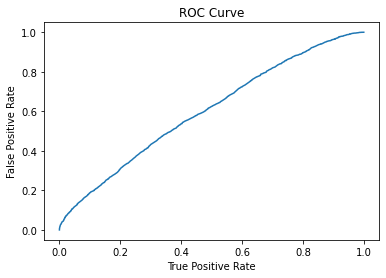

Training set areaUnderROC: 0.6016195467159198


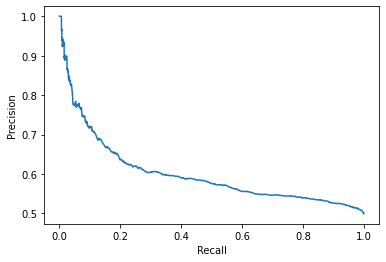

DataFrame[_c0: string, _c1: bigint, _c2: double, _c3: double, _c4: int, _c5: int, _c6: int, _c7: int, _c8: int, _c9: int, _c10: int, _c11: int, _c12: int, _c13: int, _c14: int, _c15: int, _c16: int, _c17: int, _c18: int, _c19: int, _c20: int, _c21: int, _c22: int, _c23: int, _c24: int, _c25: string, rand: string, _c25_index: double, _c25_encoded: vector, vectorized_features: vector, label: double, features: vector, rawPrediction: vector, probability: vector, prediction: double]

In [85]:
runforest(Pepe('T4smallsubset.csv'))

In [100]:
def siontree(PepePipe):
    # split
    train, test = PepePipe.randomSplit([0.8,0.2], seed=56)
    evaluator = ev.BinaryClassificationEvaluator(rawPredictionCol='probability', labelCol='label')
    #fitting and transform
    dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
    dtmodel = dt.fit(train)
    dt_pred = dtmodel.transform(test)
    
    print(evaluator.evaluate(dt_pred, {evaluator.metricName: 'areaUnderROC'}))
    print(evaluator.evaluate(dt_pred, {evaluator.metricName: 'areaUnderPR'}))

    
    return dt_pred


In [101]:
siontree(Pepe('T4smallsubset.csv'))

0.47739741992726475
0.4096869246784314


DataFrame[_c0: string, _c1: bigint, _c2: double, _c3: double, _c4: int, _c5: int, _c6: int, _c7: int, _c8: int, _c9: int, _c10: int, _c11: int, _c12: int, _c13: int, _c14: int, _c15: int, _c16: int, _c17: int, _c18: int, _c19: int, _c20: int, _c21: int, _c22: int, _c23: int, _c24: int, _c25: string, rand: string, _c25_index: double, _c25_encoded: vector, vectorized_features: vector, label: double, features: vector, rawPrediction: vector, probability: vector, prediction: double]

In [ ]:
import argparse
def main():
    #flags
    # Process command line arguments
    parser = argparse.ArgumentParser()
    parser.add_argument('--inputfile', type=str, required=True,
                      help="The file with the features and labels.")
    parser.add_argument('--split', type=int, required=False,
                      help="The train and test split of data.")


    
    FLAGS = parser.parse_args()
    #Open a file with the extracted features
    with open(FLAGS.inputfile, "r") as infile:
         data = np.loadtxt(infile, delimiter=",")


main()

In [110]:
import unittest
#import SherPyMain

#unit test
class PySparkTest(unittest.TestCase):
    
    def test_sherlock(self):
        result = SherPyMain.SherLock(Pepe('T4smallsubset.csv'))
        self.assertEqual(result, (0<result<1))
        
    def test_MoriarTree(self):
        result = SherPyMain.MoriarTree(Pepe('T4smallsubset.csv'))
        self.assertEqual(result, 0<result<1)
    
    def test_runforest(self):
        result = SherPyMain.runforest(Pepe('T4smallsubset.csv'))
        self.assertEqual(result, 0.5047279144497712)
        
    def test_siontree(self):
        result = SherPyMain.runforest(Pepe('T4smallsubset.csv'))
        self.assertEqual(result, 0.49722796337354225)
    
#if __name__ = '__main__':
   #unittest.main()